In [2]:
import torch
import pandas as pd
df = pd.read_json('/home/userroot/dev/zms/datasets/2024_04_24_index_300_keynotes.jsonl', lines=True)
# = torch.tensor(df['embeddings']).reshape(df.shape[0],1, -1).squeeze()
keynotes_emb = df['embeddings'].apply(lambda x: x[0])
news_emb = df['embeddings'].apply(lambda x: x[1])
df_embeddings = pd.DataFrame({'keynotes_emb':keynotes_emb})
df_embeddings.insert(0, 'date', df['date'])
df_embeddings.insert(1, 'code', df['code'])
df_embeddings.insert(2, 'news_emb', news_emb)

#获得股票代码对应的唯一值token编码
code_uniq = df_embeddings['code'].unique()

In [10]:

dict_arr = {value: index for index, value in enumerate(code_uniq)}
print(dict_arr)

{'sz300750': 0, 'sh600519': 1, 'sh601318': 2, 'sh600036': 3, 'sz000333': 4, 'sz000858': 5, 'sh600900': 6, 'sh601899': 7, 'sh601166': 8, 'sh600276': 9, 'sh600030': 10, 'sz002594': 11, 'sh601398': 12, 'sz000651': 13, 'sh600887': 14, 'sh601328': 15, 'sz300059': 16, 'sz300760': 17, 'sz000725': 18, 'sh600309': 19, 'sz002475': 20, 'sh600919': 21, 'sz000568': 22, 'sh601288': 23, 'sh601088': 24, 'sz300124': 25, 'sh601816': 26, 'sh600809': 27, 'sz002415': 28, 'sh601012': 29, 'sz002714': 30, 'sh600028': 31}


In [14]:
import pandas as pd

# 假设你有如下 DataFrame，其中 'group_col' 列用于分组，'col1' 和 'col2' 列包含列表
data = {
    'group_col': ['A', 'A', 'B', 'B'],
    'col1': [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]],
    'col2': [[2, 3, 4], [5, 6, 7], [8, 9, 10], [11, 12, 13]]
}
df = pd.DataFrame(data)

# 定义一个函数，用于逐元素相加两个列表
def sum_lists(group):
    col1, col2 = zip(*group)
    return [a + b for a, b in zip(col1, col2)]

# 使用 groupby 和 apply 进行逐元素相加
result = df.groupby('group_col')[['col1', 'col2']].apply(sum_lists)

# 打印结果
print(result)

ValueError: too many values to unpack (expected 2)

In [12]:
import tushare as ts
import numpy as np
pro = ts.pro_api()
# 定义一个函数，用于逐元素相加列表
def sum_lists(group):
    return [sum(a) for a in zip(*group)]
for i, g in df_embeddings.groupby('code'):
    print(g['code'].iloc[0])
    code = g['code'].iloc[0]
    part1 = code[:2]
    part2 = code[2:]

    idx = dict_arr[code]
    sorted_g = g.sort_values(by='date')

    df_day = sorted_g['date'].apply(lambda x: x.strftime('%Y%m%d'))
    sorted_g.pop('date')
    sorted_g.insert(1, 'date', df_day) 
    

    columns_to_sum = ['news_emb', 'keynotes_emb']# 'embeddings' #sorted_g.columns[3:]
    grouped_sum = sorted_g.groupby(['date'])[columns_to_sum].apply(sum_lists).reset_index()


    min_date = (df_day.min())
    max_date = (df_day.max())

    # 获取最近前后一天的交易日，如果本身是交易日则返回本身
    t_days = pro.trade_cal(exchange='SSE', end_date=min_date)
    last_trade_day = t_days[t_days['is_open']==1].iloc[0]['cal_date']
    t_days = pro.trade_cal(exchange='SSE', start_date=max_date)
    next_trade_day = t_days[t_days['is_open']==1].iloc[-1]['cal_date']
    
    df_kline = pro.daily(ts_code=part2+'.'+part1, start_date=last_trade_day, end_date=next_trade_day)
    #df_kline.to_csv(f'./index_300/{code}_kline.csv',index=False)
    print(f'trade day from {min_date} to {max_date} count: {len(df_kline)}')
    df_kline.sort_values(by='trade_date', inplace=True)
    df_kline.reset_index(inplace=True)
    df_kline['idx'] = idx

    df_kline.rename(columns={'trade_date':'date'}, inplace=True)

    merged_out = pd.merge(grouped_sum, df_kline, on=['date'], how='outer')
    
    merged_out.sort_values(by=['date'], inplace=True)
    merged_out.reset_index(inplace=True)
    #merged_out.ffill(inplace=True)
    merged_out.rename(columns={'date':'date'}, inplace=True)
    #merged_out.dropna(inplace=True)
    merged_out.pop('idx')
    merged_out.insert(1,'idx', idx)
    merged_out.pop('index')
    merged_out.pop('ts_code')

    merged_out['date'] = merged_out.apply(lambda row: np.nan if pd.isna(row['close']) else row['date'], axis=1)
    merged_out['date'].ffill(inplace=True)
    merged_out.ffill(inplace=True)
    
    columns_to_sum = ['news_emb', 'keynotes_emb'] #merged_out.columns[3:1538]
    merged_out_embedding = merged_out.groupby(['date'])[columns_to_sum].apply(sum_lists).reset_index()
    #
    merged_out = pd.merge(merged_out_embedding, df_kline, on='date', how='left')
    merged_out.pop('index')
    merged_out.pop('ts_code')
    merged_out.insert(1,'idx', merged_out.pop('idx'))

    merged_out.to_csv(f'./index_300_align_day/{code}.csv',index=False)
    break

sh600028
('n', 'k')
('e', 'e')
('w', 'y')
('s', 'n')
('_', 'o')
('e', 't')
('m', 'e')
('b', 's')


KeyboardInterrupt: 

In [50]:
merged_out

,date,idx,news_emb,keynotes_emb,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,20231214,17,"[-0.0041313772, -0.0675564408, 0.0542298295, 0...","[0.0361194611, -0.07006806880000001, 0.0901549...",299.88,301.00,293.88,295.00,297.89,-2.89,-0.9702,24728.34,731949.593
1,20231215,17,"[0.061737991900000004, -0.102987431, -0.008202...","[0.1011005044, -0.0833261237, -0.0251919273, 0...",297.99,299.05,288.00,293.00,295.00,-2.00,-0.6780,38538.83,1122104.347
2,20231218,17,"[0.0012497868, -0.0035523938000000003, 0.02720...","[-0.051575079600000004, -0.0270600598, 0.04097...",294.50,294.50,289.50,290.97,293.00,-2.03,-0.6928,25607.38,747088.072
3,20231219,17,"[0.050735388000000006, -0.0240115318, -0.00829...","[0.0619367994, -0.022160019700000002, 0.043482...",289.98,291.68,286.00,289.08,290.97,-1.89,-0.6496,23229.38,669874.761
4,20231220,17,"[0.0348521061, -0.0516428575, 0.09427364170000...","[-0.0039287838, -0.0763503686, 0.1280083507, 0...",290.15,293.80,289.08,290.35,289.08,1.27,0.4393,18850.85,549965.138
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,20240329,17,"[-0.0006033626000000001, 0.0025593580000000003...","[0.0424158387, 0.0066694012, 0.0159470011, 0.0...",279.99,282.75,279.00,281.46,279.89,1.57,0.5609,20211.24,566899.194
70,20240401,17,"[-0.0263203494, -0.1102391779, 0.0246765595, 0...","[-0.09093514080000001, -0.12080761790000001, -...",281.46,286.73,281.00,282.75,281.46,1.29,0.4583,25892.49,734872.172
71,20240402,17,"[-0.0316895694, -0.081759803, 0.02674919930000...","[-0.004729711, -0.12223820390000001, 0.0102153...",282.88,282.93,279.50,281.47,282.75,-1.28,-0.4527,27122.55,762355.046
72,20240403,17,"[-0.0088183917, -0.1027836874, 0.024169419, 0....","[0.0008649793, -0.09416745600000001, 0.0094450...",280.20,283.18,280.08,281.32,281.47,-0.15,-0.0533,28442.60,801137.121


In [51]:
merged_out_embedding

,date,news_emb,keynotes_emb
0,20231214,"[-0.0041313772, -0.0675564408, 0.0542298295, 0...","[0.0361194611, -0.07006806880000001, 0.0901549..."
1,20231215,"[0.061737991900000004, -0.102987431, -0.008202...","[0.1011005044, -0.0833261237, -0.0251919273, 0..."
2,20231218,"[0.0012497868, -0.0035523938000000003, 0.02720...","[-0.051575079600000004, -0.0270600598, 0.04097..."
3,20231219,"[0.050735388000000006, -0.0240115318, -0.00829...","[0.0619367994, -0.022160019700000002, 0.043482..."
4,20231220,"[0.0348521061, -0.0516428575, 0.09427364170000...","[-0.0039287838, -0.0763503686, 0.1280083507, 0..."
...,...,...,...
69,20240329,"[-0.0006033626000000001, 0.0025593580000000003...","[0.0424158387, 0.0066694012, 0.0159470011, 0.0..."
70,20240401,"[-0.0263203494, -0.1102391779, 0.0246765595, 0...","[-0.09093514080000001, -0.12080761790000001, -..."
71,20240402,"[-0.0316895694, -0.081759803, 0.02674919930000...","[-0.004729711, -0.12223820390000001, 0.0102153..."
72,20240403,"[-0.0088183917, -0.1027836874, 0.024169419, 0....","[0.0008649793, -0.09416745600000001, 0.0094450..."


In [52]:
merged_out['date'] = merged_out.apply(lambda row: np.nan if pd.isna(row['close']) else row['date'], axis=1)

In [53]:
merged_out['date'].ffill(inplace=True)

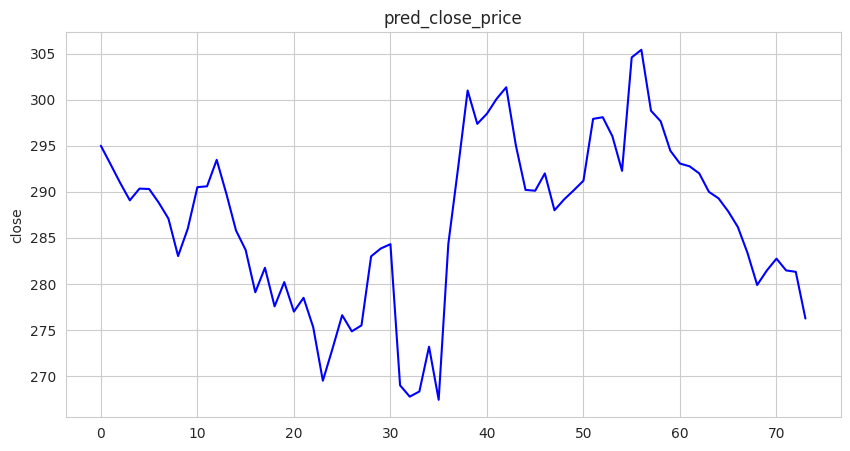

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.lineplot(data=merged_out['close'], color='blue')
#sns.lineplot(data=df_kline['close'], color='red')
# Adding title
plt.title('pred_close_price')

# Display the plot
plt.show()

In [55]:
merged_out

,date,idx,news_emb,keynotes_emb,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,20231214,17,"[-0.0041313772, -0.0675564408, 0.0542298295, 0...","[0.0361194611, -0.07006806880000001, 0.0901549...",299.88,301.00,293.88,295.00,297.89,-2.89,-0.9702,24728.34,731949.593
1,20231215,17,"[0.061737991900000004, -0.102987431, -0.008202...","[0.1011005044, -0.0833261237, -0.0251919273, 0...",297.99,299.05,288.00,293.00,295.00,-2.00,-0.6780,38538.83,1122104.347
2,20231218,17,"[0.0012497868, -0.0035523938000000003, 0.02720...","[-0.051575079600000004, -0.0270600598, 0.04097...",294.50,294.50,289.50,290.97,293.00,-2.03,-0.6928,25607.38,747088.072
3,20231219,17,"[0.050735388000000006, -0.0240115318, -0.00829...","[0.0619367994, -0.022160019700000002, 0.043482...",289.98,291.68,286.00,289.08,290.97,-1.89,-0.6496,23229.38,669874.761
4,20231220,17,"[0.0348521061, -0.0516428575, 0.09427364170000...","[-0.0039287838, -0.0763503686, 0.1280083507, 0...",290.15,293.80,289.08,290.35,289.08,1.27,0.4393,18850.85,549965.138
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,20240329,17,"[-0.0006033626000000001, 0.0025593580000000003...","[0.0424158387, 0.0066694012, 0.0159470011, 0.0...",279.99,282.75,279.00,281.46,279.89,1.57,0.5609,20211.24,566899.194
70,20240401,17,"[-0.0263203494, -0.1102391779, 0.0246765595, 0...","[-0.09093514080000001, -0.12080761790000001, -...",281.46,286.73,281.00,282.75,281.46,1.29,0.4583,25892.49,734872.172
71,20240402,17,"[-0.0316895694, -0.081759803, 0.02674919930000...","[-0.004729711, -0.12223820390000001, 0.0102153...",282.88,282.93,279.50,281.47,282.75,-1.28,-0.4527,27122.55,762355.046
72,20240403,17,"[-0.0088183917, -0.1027836874, 0.024169419, 0....","[0.0008649793, -0.09416745600000001, 0.0094450...",280.20,283.18,280.08,281.32,281.47,-0.15,-0.0533,28442.60,801137.121
